In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

from data.util import *
from descriptiveAnalytics.utils import *

In [4]:
dow_johnes = load_data_from_folder(DATA_FOLDERS[0])
ftse_100 = load_data_from_folder(DATA_FOLDERS[1])
nikkei_225 = load_data_from_folder(DATA_FOLDERS[2])
sp_500 = load_data_from_folder(DATA_FOLDERS[3])
EGX_30 = load_data_from_folder(DATA_FOLDERS[4])

dfs = {
    Indices.dow_Jones.name  : dow_johnes,
    Indices.ftse_100.name   : ftse_100,
    Indices.nikkei_225.name : nikkei_225,
    Indices.sp_500.name     : sp_500,
    Indices.EGX_30.name     : EGX_30}

In [5]:
colNames = []
for index in Indices:
    for col in ColumnNames:
        if "Date" not in col.name:
            colNames.append(f"{index.name}_{col.name}")
indices = []
for index in Indices:
    indices.append(index.name)
            
for df in dfs:
    dfs[df] = cast_columns_to_double(dfs[df])
    dfs[df] = rename_columns(dfs[df], df)
    print(f"{df}: ")
    print(f"{dfs[df]}")
    dfs[df].describe().show()

dow_Jones: 
DataFrame[Date: string, dow_Jones_Close: double, dow_Jones_High: double, dow_Jones_Low: double, dow_Jones_Open: double, dow_Jones_Volume: double]
+-------+----------+------------------+-----------------+------------------+------------------+--------------------+
|summary|      Date|   dow_Jones_Close|   dow_Jones_High|     dow_Jones_Low|    dow_Jones_Open|    dow_Jones_Volume|
+-------+----------+------------------+-----------------+------------------+------------------+--------------------+
|  count|      3522|              3522|             3522|              3522|              3522|                3522|
|   mean|      NULL|21712.507973596767|21825.74421354832|21584.509138983532|21707.796203439986| 2.384138358886996E8|
| stddev|      NULL| 8037.528384265559|8081.914849522401| 7991.416107733758| 8037.466348928835|1.3382979847076967E8|
|    min|2010-01-04|     9686.48046875|  9770.8701171875|      9614.3203125|     9686.48046875|           8410000.0|
|    max|2023-12-29|   

In [6]:
# merged_df_outer_join = EGX_30.join(sp_500, "Date", "outer") \
#                      .join(ftse_100, "Date", "outer") \
#                      .join(nikkei_225, "Date", "outer") \
#                      .join(dow_johnes, "Date", "outer") 

# merged_df_outer_join.count()
# merged_df_outer_join = cast_columns_to_double(merged_df_outer_join)

In [7]:
merged_df_inner_join = dfs[Indices.EGX_30.name].join(dfs[Indices.sp_500.name], "Date", "inner") \
                     .join(dfs[Indices.ftse_100.name], "Date", "inner") \
                     .join(dfs[Indices.nikkei_225.name], "Date", "inner") \
                     .join(dfs[Indices.dow_Jones.name], "Date", "inner")
merged_df_inner_join = cast_columns_to_double(merged_df_inner_join)
merged_df_inner_join = merged_df_inner_join.dropna()

In [8]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col, when

# Define a window specification
window_spec = Window.partitionBy().orderBy("Date")

daily_return_dfs = []
daily_return_df = merged_df_inner_join

for df in dfs:
    col_name = f"{df}_{ColumnNames.Close.name}"
    daily_return_dfs.append(f"{df}_daily_return")
    daily_return_df = daily_return_df.withColumn(
        f"{df}_daily_return",
        when(
        lag(col_name, 1).over(window_spec).isNotNull(),
        (col(col_name) - lag(col_name, 1).over(window_spec)) / lag(col_name, 1).over(window_spec)
        ).otherwise(0)
    )

daily_return_df = daily_return_df.select(["Date"] + daily_return_dfs)

daily_return_df.describe().show()
daily_return_df.show(5)
daily_return_df = daily_return_df.toPandas()

+-------+----------+----------------------+---------------------+-----------------------+--------------------+--------------------+
|summary|      Date|dow_Jones_daily_return|ftse_100_daily_return|nikkei_225_daily_return| sp_500_daily_return| EGX_30_daily_return|
+-------+----------+----------------------+---------------------+-----------------------+--------------------+--------------------+
|  count|      2836|                  2836|                 2836|                   2836|                2836|                2836|
|   mean|      NULL|  5.191879687659587E-4| 1.819534268810763...|   5.053858852278603E-4|5.788227024205645E-4|6.146590222596735E-4|
| stddev|      NULL|   0.01187299425876439|  0.01112017822674024|   0.014182108548995445|0.011858730470301684| 0.01635592096124115|
|    min|2010-01-04|  -0.14285524745363495| -0.12344080700140389|   -0.12433116792909543| -0.1295880232532872|-0.15768814341815168|
|    max|2023-12-28|    0.1136504119941154|  0.09053046847095778|    0.08038


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1085  , p=0.7419  , df_denom=2832, df_num=1
ssr based chi2 test:   chi2=0.1086  , p=0.7417  , df=1
likelihood ratio test: chi2=0.1086  , p=0.7417  , df=1
parameter F test:         F=0.1085  , p=0.7419  , df_denom=2832, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0568  , p=0.3477  , df_denom=2829, df_num=2
ssr based chi2 test:   chi2=2.1172  , p=0.3469  , df=2
likelihood ratio test: chi2=2.1165  , p=0.3471  , df=2
parameter F test:         F=1.0568  , p=0.3477  , df_denom=2829, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5703  , p=0.0526  , df_denom=2826, df_num=3
ssr based chi2 test:   chi2=7.7301  , p=0.0519  , df=3
likelihood ratio test: chi2=7.7196  , p=0.0522  , df=3
parameter F test:         F=2.5703  , p=0.0526  , df_denom=2826, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3144  , p=0.

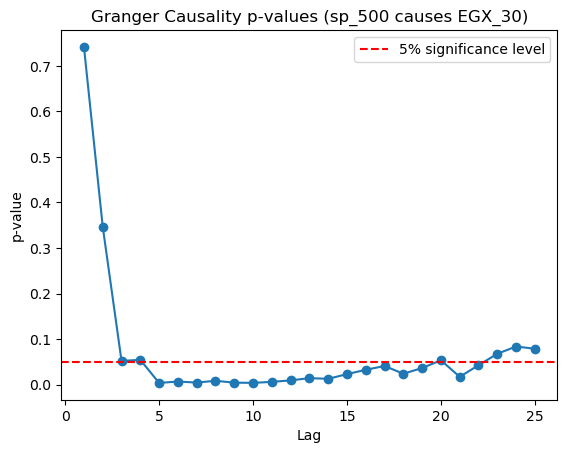


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.0118 , p=0.0009  , df_denom=2832, df_num=1
ssr based chi2 test:   chi2=11.0235 , p=0.0009  , df=1
likelihood ratio test: chi2=11.0021 , p=0.0009  , df=1
parameter F test:         F=11.0118 , p=0.0009  , df_denom=2832, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.0656  , p=0.0009  , df_denom=2829, df_num=2
ssr based chi2 test:   chi2=14.1562 , p=0.0008  , df=2
likelihood ratio test: chi2=14.1209 , p=0.0009  , df=2
parameter F test:         F=7.0656  , p=0.0009  , df_denom=2829, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8833  , p=0.0022  , df_denom=2826, df_num=3
ssr based chi2 test:   chi2=14.6861 , p=0.0021  , df=3
likelihood ratio test: chi2=14.6481 , p=0.0021  , df=3
parameter F test:         F=4.8833  , p=0.0022  , df_denom=2826, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.3789  , p=0.

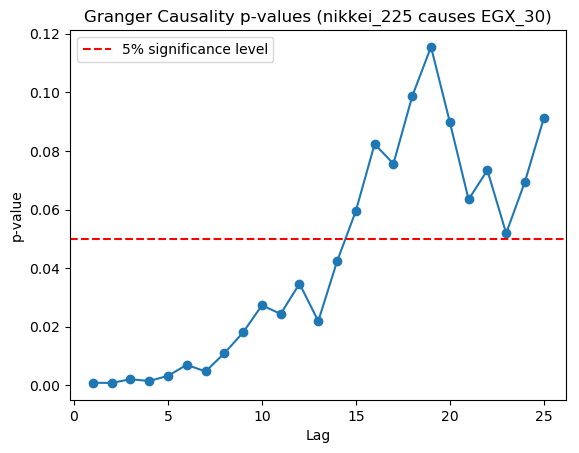


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9078  , p=0.0883  , df_denom=2832, df_num=1
ssr based chi2 test:   chi2=2.9109  , p=0.0880  , df=1
likelihood ratio test: chi2=2.9094  , p=0.0881  , df=1
parameter F test:         F=2.9078  , p=0.0883  , df_denom=2832, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3294  , p=0.0133  , df_denom=2829, df_num=2
ssr based chi2 test:   chi2=8.6740  , p=0.0131  , df=2
likelihood ratio test: chi2=8.6608  , p=0.0132  , df=2
parameter F test:         F=4.3294  , p=0.0133  , df_denom=2829, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5514  , p=0.0139  , df_denom=2826, df_num=3
ssr based chi2 test:   chi2=10.6805 , p=0.0136  , df=3
likelihood ratio test: chi2=10.6604 , p=0.0137  , df=3
parameter F test:         F=3.5514  , p=0.0139  , df_denom=2826, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5444  , p=0.

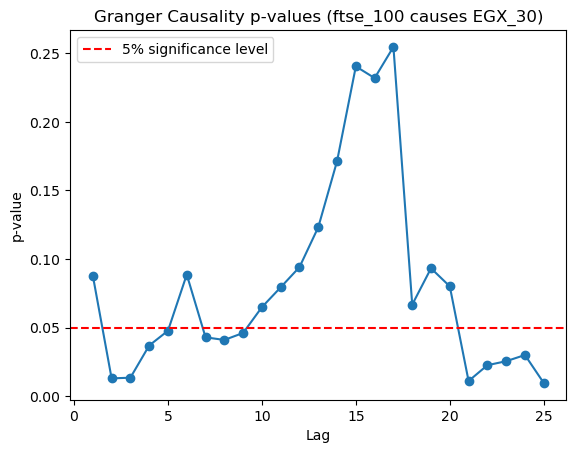


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0837  , p=0.7724  , df_denom=2832, df_num=1
ssr based chi2 test:   chi2=0.0838  , p=0.7722  , df=1
likelihood ratio test: chi2=0.0838  , p=0.7722  , df=1
parameter F test:         F=0.0837  , p=0.7724  , df_denom=2832, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1335  , p=0.3221  , df_denom=2829, df_num=2
ssr based chi2 test:   chi2=2.2709  , p=0.3213  , df=2
likelihood ratio test: chi2=2.2700  , p=0.3214  , df=2
parameter F test:         F=1.1335  , p=0.3221  , df_denom=2829, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9406  , p=0.0319  , df_denom=2826, df_num=3
ssr based chi2 test:   chi2=8.8436  , p=0.0314  , df=3
likelihood ratio test: chi2=8.8298  , p=0.0316  , df=3
parameter F test:         F=2.9406  , p=0.0319  , df_denom=2826, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0494  , p=0.

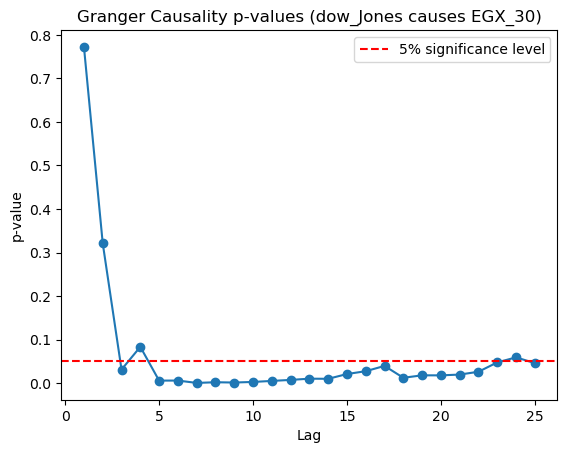

In [9]:
max_lag = 25

for index in indices:
    if "EGX" in index:
        continue
        
    gc_test_result = grangercausalitytests(daily_return_df[[f'{index}_daily_return', f'{Indices.EGX_30.name}_daily_return']], max_lag)

    lags = list(range(1, max_lag + 1))
    p_values = [gc_test_result[lag][0]['ssr_chi2test'][1] for lag in range(1, max_lag + 1)]
    
    plt.plot(lags, p_values, marker='o')
    plt.axhline(y=0.05, color='r', linestyle='--', label="5% significance level")
    plt.xlabel('Lag')
    plt.ylabel('p-value')
    plt.title(f"Granger Causality p-values ({index} causes EGX_30)")
    plt.legend()
    plt.show()


In [10]:
corr_mat = np.zeros((len(dfs), len(dfs)))
indices_ordered = []
for x, xdf in enumerate(dfs):
    indices_ordered.append(xdf)
    for y, ydf in enumerate(dfs):
        corr_mat[x,y] = merged_df_inner_join.stat.corr(f"{xdf}_{ColumnNames.Close.name}", f"{ydf}_{ColumnNames.Close.name}")
        # print(f"{xdf}_{ColumnNames.Close.name}", f"{ydf}_{ColumnNames.Close.name} , {corr_mat[x,y]}")

dow_Jones_Close dow_Jones_Close , 1.0
dow_Jones_Close ftse_100_Close , 0.7547967942141945
dow_Jones_Close nikkei_225_Close , 0.9663818851617242
dow_Jones_Close sp_500_Close , 0.9930098765984532
dow_Jones_Close EGX_30_Close , 0.7578638930250737
ftse_100_Close dow_Jones_Close , 0.7547967942141947
ftse_100_Close ftse_100_Close , 1.0
ftse_100_Close nikkei_225_Close , 0.7844340978624856
ftse_100_Close sp_500_Close , 0.7184219764105493
ftse_100_Close EGX_30_Close , 0.7902903351813237
nikkei_225_Close dow_Jones_Close , 0.9663818851617242
nikkei_225_Close ftse_100_Close , 0.7844340978624856
nikkei_225_Close nikkei_225_Close , 1.0
nikkei_225_Close sp_500_Close , 0.9646054424965086
nikkei_225_Close EGX_30_Close , 0.7873219777342894
sp_500_Close dow_Jones_Close , 0.9930098765984532
sp_500_Close ftse_100_Close , 0.7184219764105493
sp_500_Close nikkei_225_Close , 0.9646054424965086
sp_500_Close sp_500_Close , 1.0
sp_500_Close EGX_30_Close , 0.7177698993251508
EGX_30_Close dow_Jones_Close , 0.757863

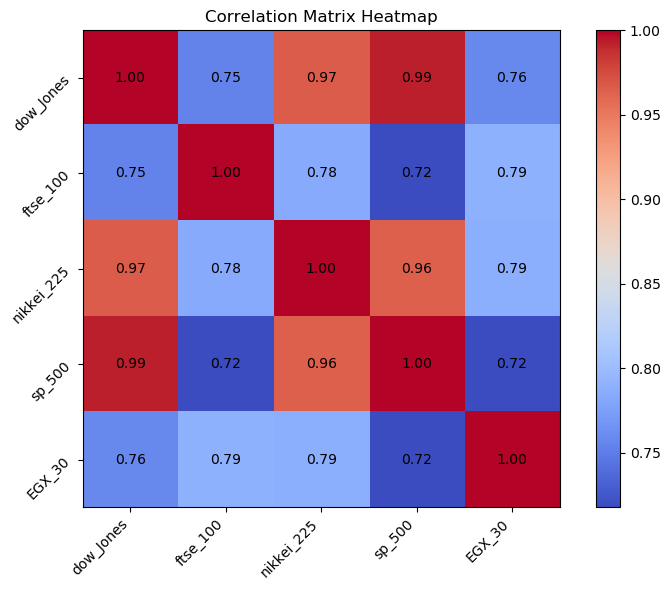

In [11]:
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(corr_mat, cmap="coolwarm", interpolation="nearest")

plt.colorbar(heatmap)

plt.xticks(np.arange(len(indices_ordered)), indices_ordered, rotation=45, ha="right")
plt.yticks(np.arange(len(indices_ordered)), indices_ordered, rotation=45)

# Add annotations
for i in range(len(indices)):
    for j in range(len(indices)):
        plt.text(i, j, f"{corr_mat[i, j]:.2f}", ha="center", va="center", color="black")

# Title and layout
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

In [12]:
for col in colNames:
    summary = calculate_summary_stats(merged_df_inner_join,[col])
    summary.show()

+------------------+------------------+------------------+---------------+--------------------+
|  sp_500_Open_mean|sp_500_Open_stddev|   sp_500_Open_min|sp_500_Open_max|sp_500_Open_skewness|
+------------------+------------------+------------------+---------------+--------------------+
|2520.6860055425777| 1057.964209232941|1028.0899658203125| 4804.509765625|  0.5152976703738176|
+------------------+------------------+------------------+---------------+--------------------+

+------------------+-------------------+----------------+----------------+---------------------+
| sp_500_Close_mean|sp_500_Close_stddev|sp_500_Close_min|sp_500_Close_max|sp_500_Close_skewness|
+------------------+-------------------+----------------+----------------+---------------------+
|2520.9199361222754| 1057.9851392150438|1028.06005859375| 4793.5400390625|   0.5160010776062546|
+------------------+-------------------+----------------+----------------+---------------------+

+------------------+-------------

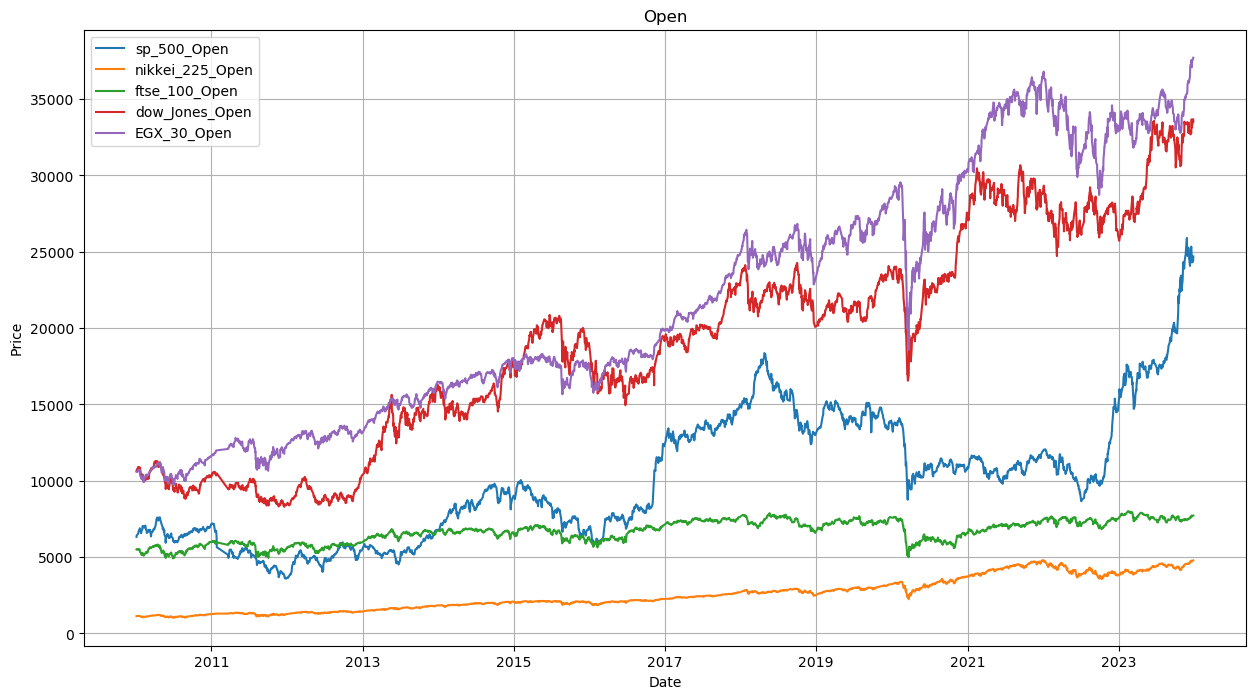

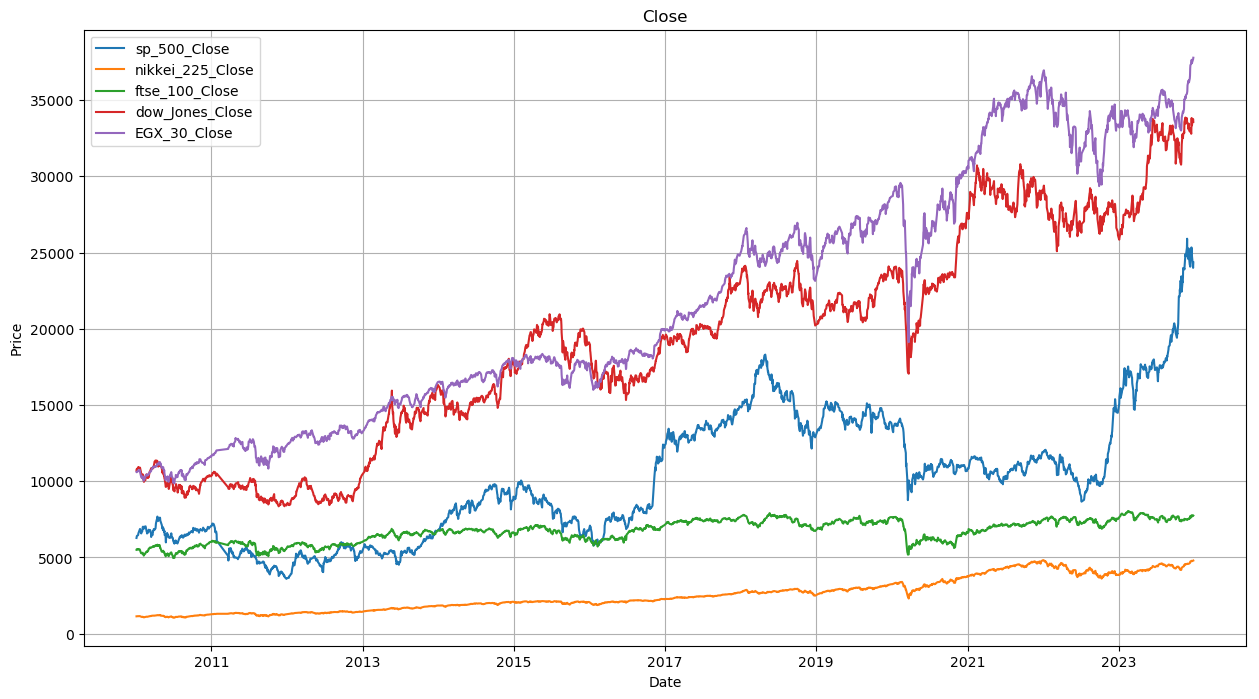

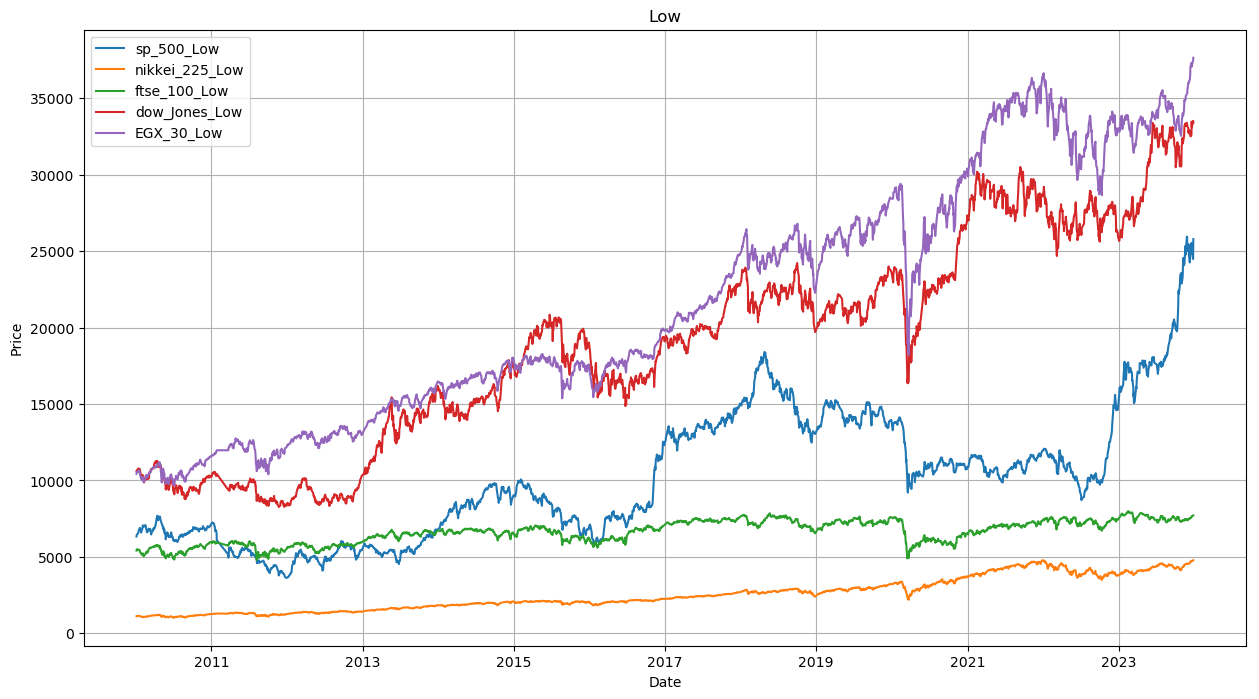

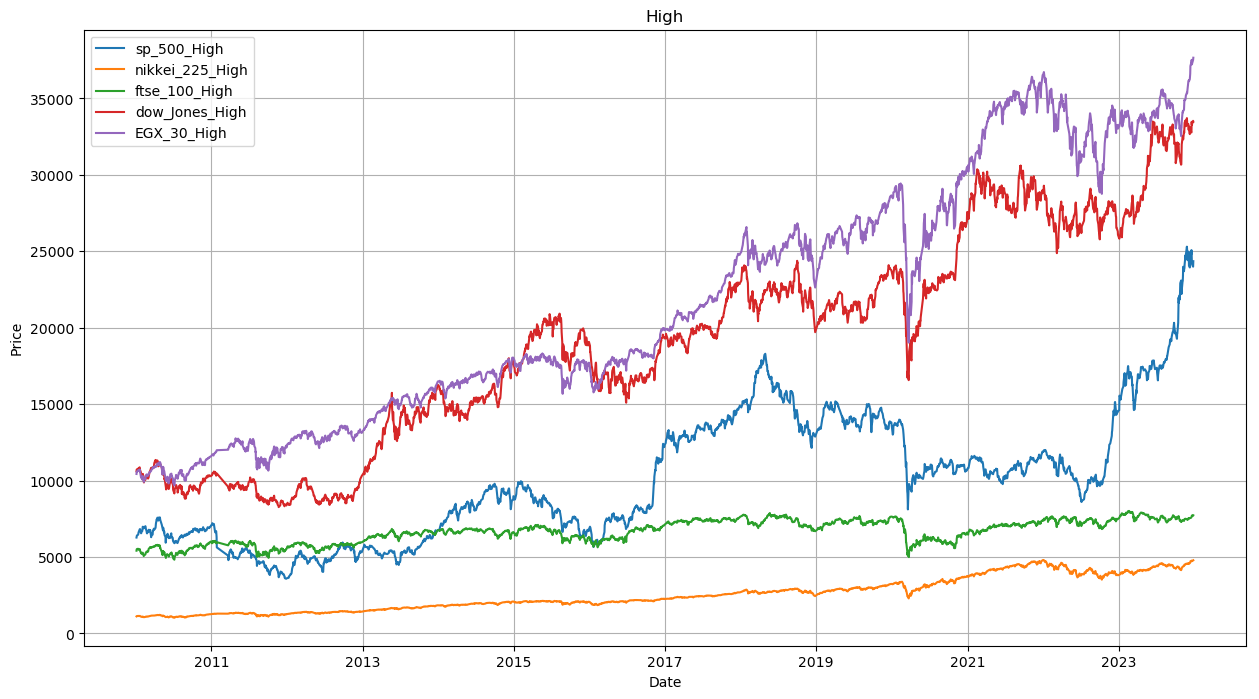

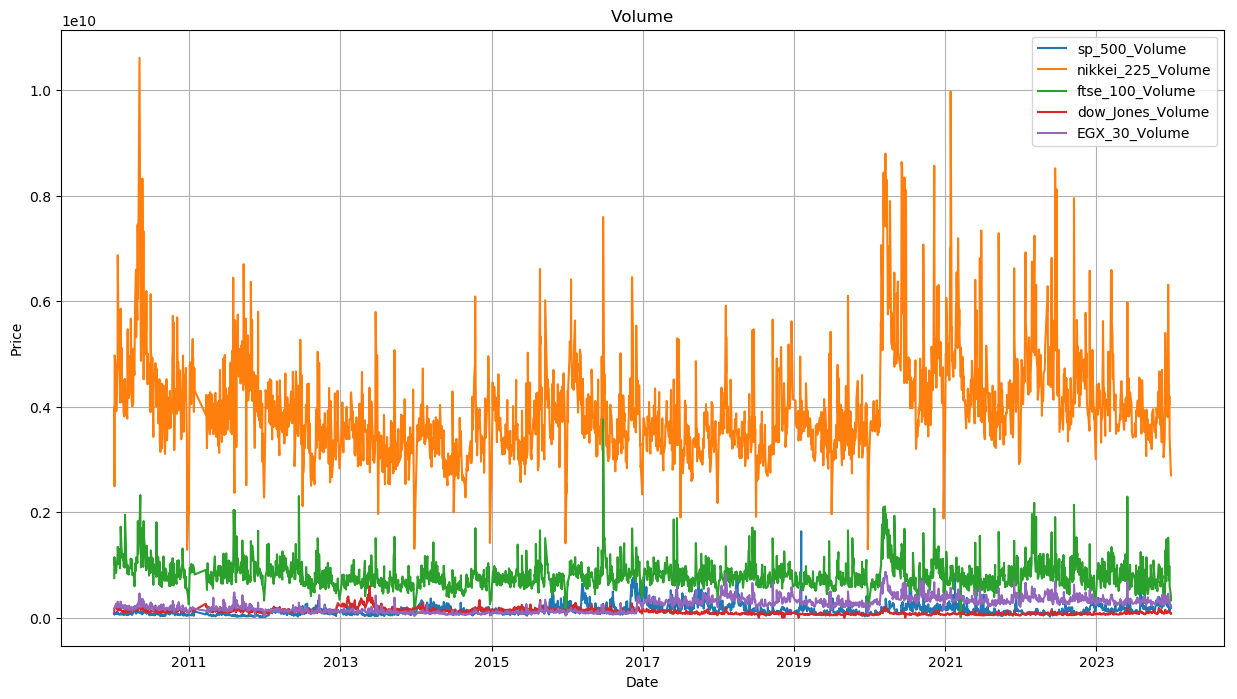

In [13]:
pdf = merged_df_inner_join.select(["Date"] + merged_df_inner_join.columns[1:]).orderBy("Date").toPandas().to_numpy()
for i in range(5):
    plot_numpy_array(
        data= pdf,
        column_names=["Date"] + colNames,
        date_col="Date",
        price_cols=colNames[i::5],
        title=colNames[i::5][0].split("_")[-1]
    )

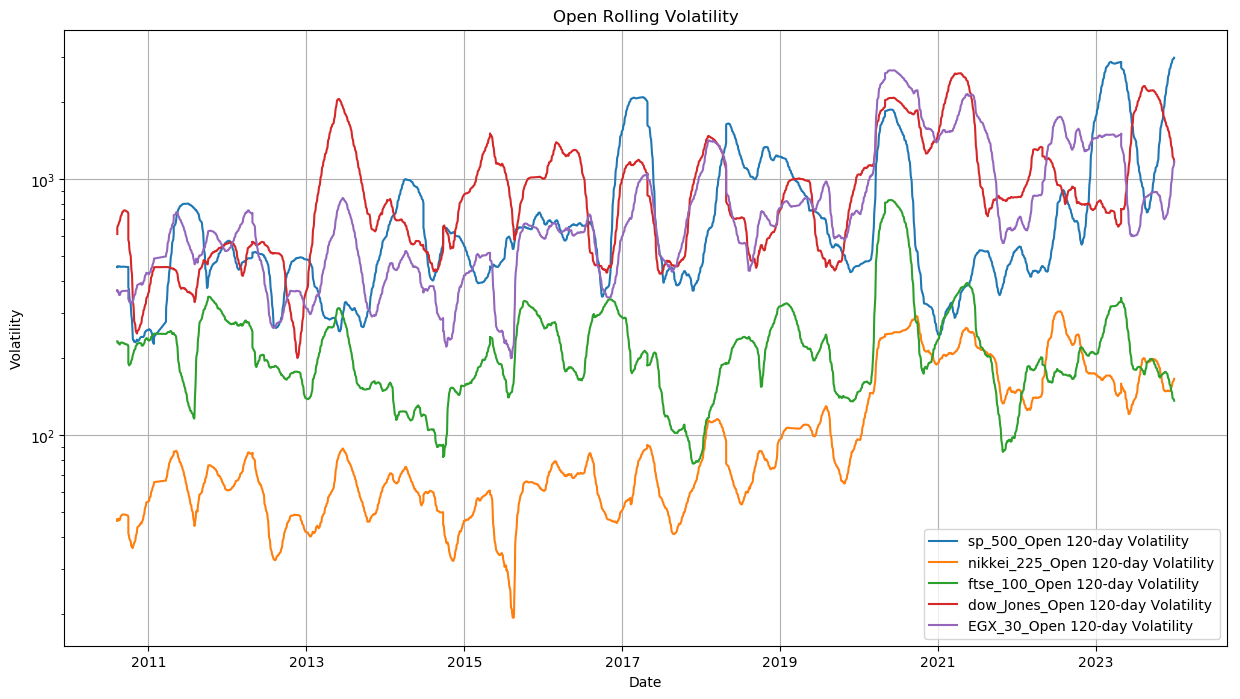

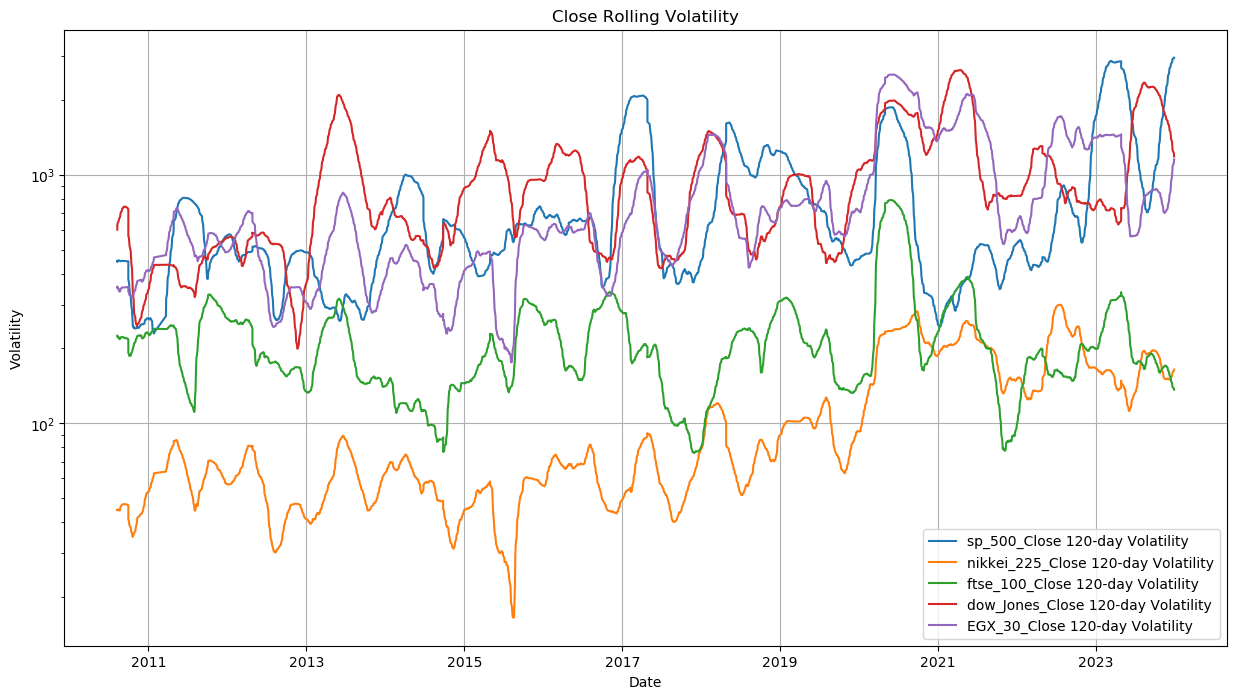

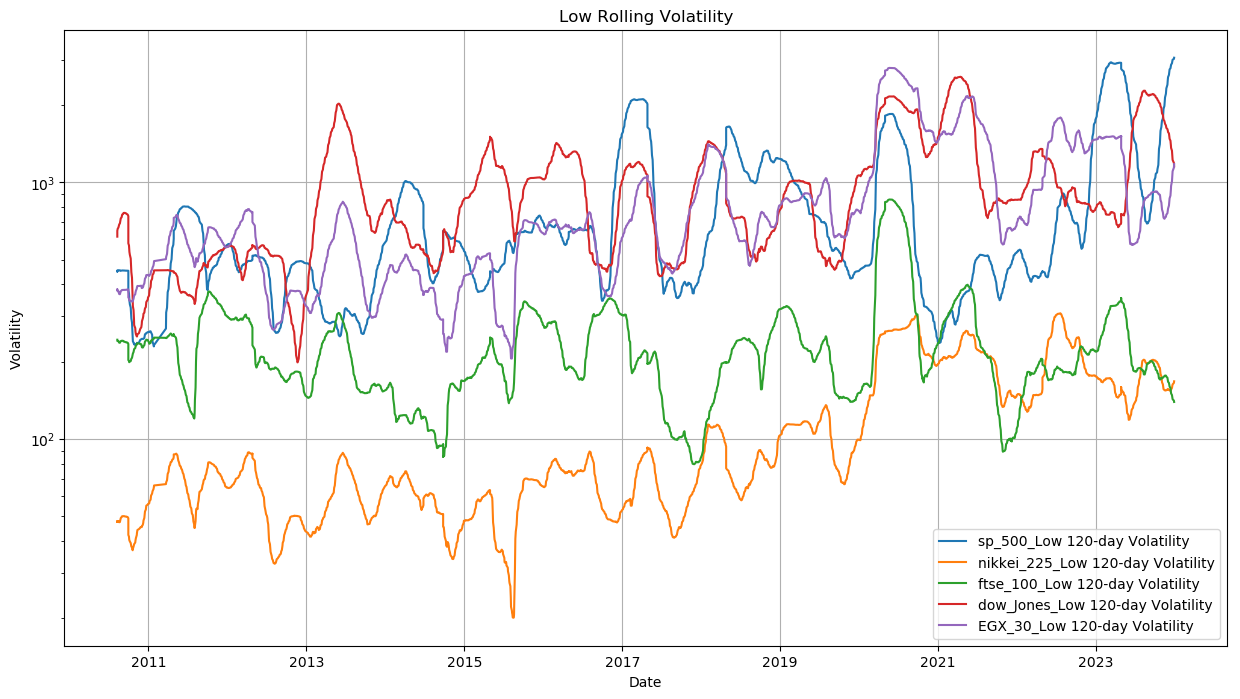

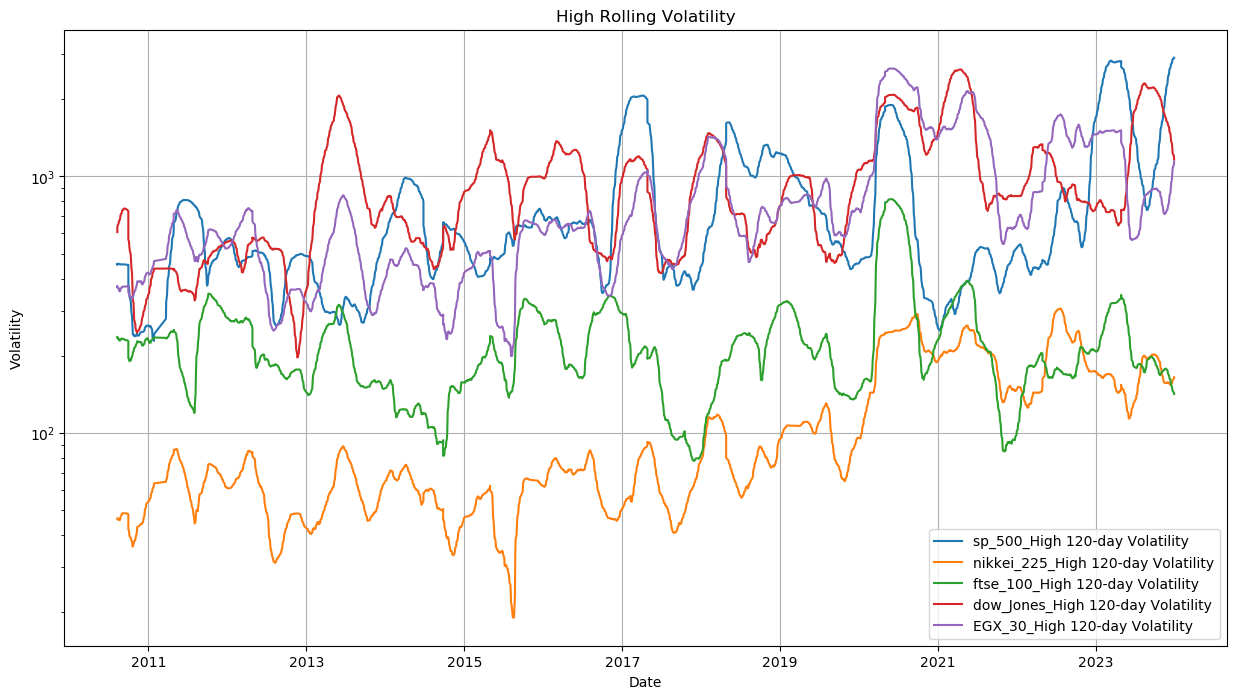

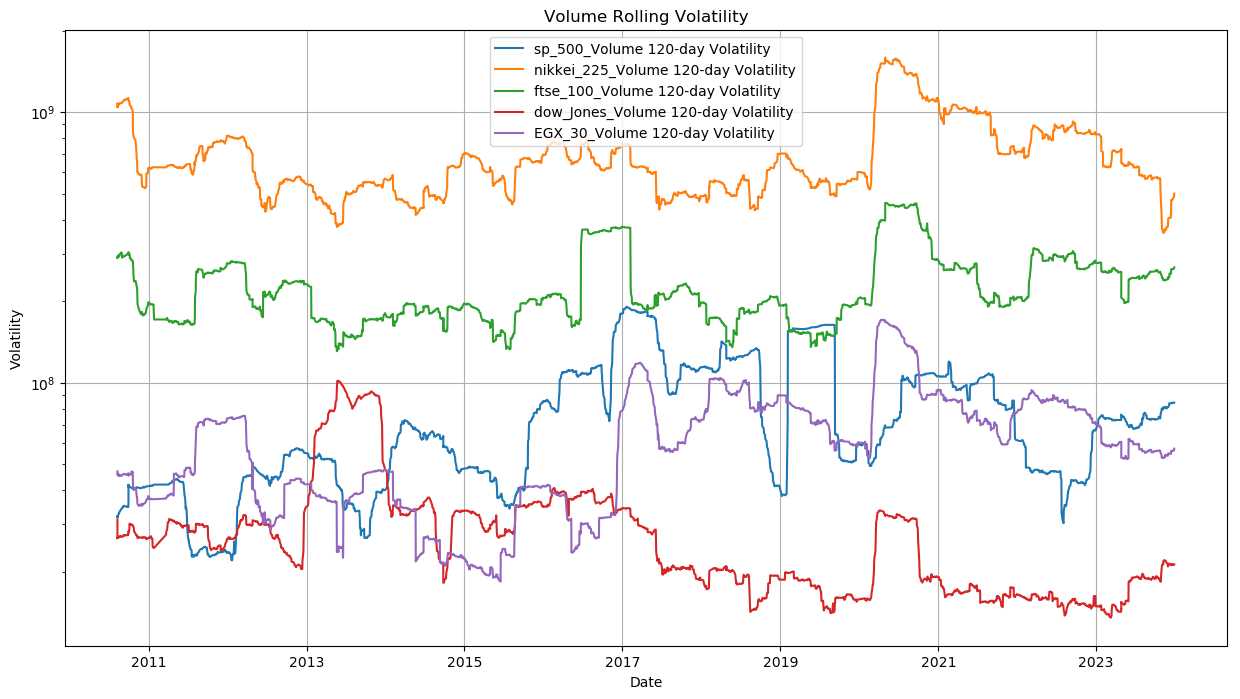

In [14]:
for i in range(5):
    plot_rolling_volatility(
        data=pdf,
        column_names=["Date"] + colNames,
        date_col="Date",
        price_cols=colNames[i::5],
        window=120,
        title= colNames[i::5][0].split("_")[-1] + " Rolling Volatility"
    )

In [1]:
from arch import arch_model
from arch.__future__ import reindexing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import multivariate

# Fitting a bivariate GARCH model
model = multivariate.DCC_GARCH(returns_egx30, returns_sp500, p=1, q=1)

# Fit the model
results = model.fit()

# Check the results
print(results.summary())

# Forecast the conditional volatilities
forecast = results.forecast(horizon=5)
volatility_forecast_egx30 = forecast.variance[0, -1]
volatility_forecast_sp500 = forecast.variance[1, -1]

# Visualize the forecasted volatility
plt.plot(volatility_forecast_egx30, label='EGX30 Volatility')
plt.plot(volatility_forecast_sp500, label='SP500 Volatility')
plt.legend()
plt.title('Volatility Forecasts with DCC-GARCH')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.show()


ImportError: cannot import name 'multivariate' from 'arch' (C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\arch\__init__.py)

In [3]:
from arch import arch_model

# Define the GARCH model (1, 1) for the returns
returns = daily_return_df['dow_Jones_daily_return']
model = arch_model(returns, vol='Garch', p=1, q=1)

# Fit the model
garch_fit = model.fit(disp="off")
print(garch_fit.summary())

NameError: name 'daily_return_df' is not defined